## 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import xlsxwriter
from PIL import Image

pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Data

In [ ]:
fname = '.xlsx'

In [3]:
df = pd.read_excel(fname)

In [4]:
df.head(1)

,wine_id,merchant_name,price,price_avg,url,wine_name,wine_type_id,region,country,winery,region_style,style_body,acidity,grape_1,grape_2,grape_3,ratings_count_wine,ratings_average_wine,is_natural,image_vivino,critics_score_avg,style,score,vivino_link,winery_wines_count,winery_ratings_sum
0,1536432,balticxl.lt,10.0,11.0,https://www.balticxl.lt/khareba-kindzmarauli,Kindzmarauli (ქინძმარაული) Semi-Sweet Red,Red,Kindzmarauli,Georgia,Khareba,NaN,NaN,NaN,NaN,NaN,NaN,2247,4.4,NaN,//images.vivino.com/thumbs/0HWfewO1QEao_Gc-qnW...,NaN,Fruity Red,0.9,https://www.vivino.com/w/1536432,53,22844


## Preprocessing

### Functions

In [9]:
region_count = df.groupby('region')['wine_id'].count()
region_count = region_count.map(lambda x: x>2000)
region_count = dict(region_count)
df['region_big'] = [r if region_count[r] else c+'_other'
                         for r,c in df[['region','country']].values]

False    3435
True      119
Name: wine_id, dtype: int64


In [13]:
def get_price_group_l1(x):
    if x<=7:
        return '0-7.0' 
    
    elif (x>7)and(x<=10):
        return '7.0-10.0'
    
    elif (x>10)and(x<=13.25):
        return '10.0-13.25'
    
    elif (x>13.25)and(x<=17.34):
        return '13.25-17.34'
    
    elif (x>17.34)and(x<=24.05):
        return '17.34-24.05'
    
    elif (x>24.05)and(x<=40.8):
        return '24.05-40.8'
    
    elif (x>40.8)and(x<=151.01):
        return '40.8-151.01'

df['price_group_l1'] = df['price_avg'].apply(lambda x: get_price_group_l1(x))

In [14]:
def get_price_group_l2(x):
    if x<=7:
        return '0-07' 
    
    elif (x>7)and(x<=10):
        return '07-10'
    
    elif (x>10)and(x<=15):
        return '10-15'
    
    elif (x>15)and(x<=20):
        return '15-20'
    
    elif (x>20)and(x<=25):
        return '20-25'
    
    elif (x>25)and(x<=40):
        return '25-40'
    else:
        return '40+'

df['price_group_l2'] = df['price'].apply(lambda x: get_price_group_l2(x))

### Process

In [15]:
df

## Functions

### Script

In [45]:
def func_param_plot(workbook, sheet, offset,
                    crosstab=None,
                    df=None, context=None, research=None, funcs=None,
                    path_plot='', title_plot=None, width=8, height=3, x_rotation=0, y_rotation=0,
                    title_sheet=None, show=True, photo_num=''):
    
    if crosstab is None:
        if type(context) is str:
            crosstab = df.groupby(context, sort=True)[research].agg(funcs).T
        elif type(context) is list:
            crosstab = pd.crosstab(df[context[0]], df[context[1]], df[research], aggfunc=funcs).sort_index()
    
    #высота в клетках height*5.25
    #длина в клетках width*1.25
    plt.rcParams["figure.figsize"] = (width, height)

    for i in crosstab.index:
        ct = crosstab.copy()
        for ii in crosstab.index:
            if ii != i:
                ct.loc[ii] = float('nan')
        if type(ct.loc[i, crosstab.columns[1]]) is int:
            fmt='.0f'
        else:
            fmt='.1f'
        sns.heatmap(ct, annot=True, cbar=False, fmt=fmt, cmap=plt.cm.get_cmap('Blues'))

    if title_plot:
        plt.title(title_plot)

    plt.yticks(rotation=y_rotation)
    plt.xticks(rotation=x_rotation)
    
    plotpath = os.path.join(path_plot, sheet+photo_num+'.png')
    plt.savefig(plotpath, bbox_inches='tight')
    
    if show:
        plt.show()
    
    worksheet = workbook.get_worksheet_by_name(sheet)
    if worksheet is None:
        worksheet = workbook.add_worksheet(name=sheet)
    
    if title_sheet:
        worksheet.write(offset, 0, title_sheet)
        offset += 3
    
    worksheet.insert_image(offset, 0, plotpath)
    im = Image.open(plotpath)
    width, height = im.size
    offset += round(height / 21 + 1) + 1
    
    return offset+1

In [20]:
def func_param_examples(df, context, research, funcs,
                          workbook, sheet, offset,
                          top=5, show=True):
    
    if type(context) is str:
        context = [None, context]
    
    worksheet = workbook.get_worksheet_by_name(sheet)
    if worksheet is None:
        worksheet = workbook.add_worksheet(name=sheet)
        
    for c1 in np.sort(df[context[0]].unique()) if context[0] is not None else ['']:
        
        if context[0] is not None:
            df_tmp1 = df[df[context[0]] == c1].copy()
        else:
            df_tmp1 = df.copy()
        
        for c2 in np.sort(df[context[1]].unique()):
            
            df_tmp2 = df_tmp1[df_tmp1[context[1]] == c2].copy()

            worksheet.write(offset, 0, c1+' '+c2)
            offset += 1

            if df_tmp2.shape[0] == 0:
                
                worksheet.write(offset, 0, 'There is no wines in '+c1+' '+c2)
                offset += 2
                
            else:
                  
                for f in funcs:

                    if f == 'min':
                        df_tmp3 = df_tmp2.sort_values(research, ascending=True).head(top)
                    elif f == 'max':
                        df_tmp3 = df_tmp2.sort_values(research, ascending=False).head(top)
                        
                    worksheet.write(offset, 0, 'Examples. '+f+' '+research+' in '+c1+' '+c2)
                    offset += 1
                    
                    if show:
                        display(df_tmp3)
                    offset = write_df_to_excel(df_tmp3, worksheet, offset, 0, with_index=False)
    
    return offset+1

In [21]:
def write_df_to_excel(df, worksheet, startrow, startcol, with_index=False):

    if with_index:
        df = df.reset_index()

    df_cols = df.columns.tolist()
    row = startrow
    col = startcol
    for c in df_cols:
        worksheet.write(row, col, c)
        col = col + 1

    df_list = []
    for i in range(df.shape[0]):
        df_list.append(df.iloc[i].tolist())

    row = row + 1
    for r in df_list:
        col = startcol

        for rr in r:
            worksheet.write(row, col, str(rr))
            col = col + 1
        row = row + 1
    
    return row+1

### Examples

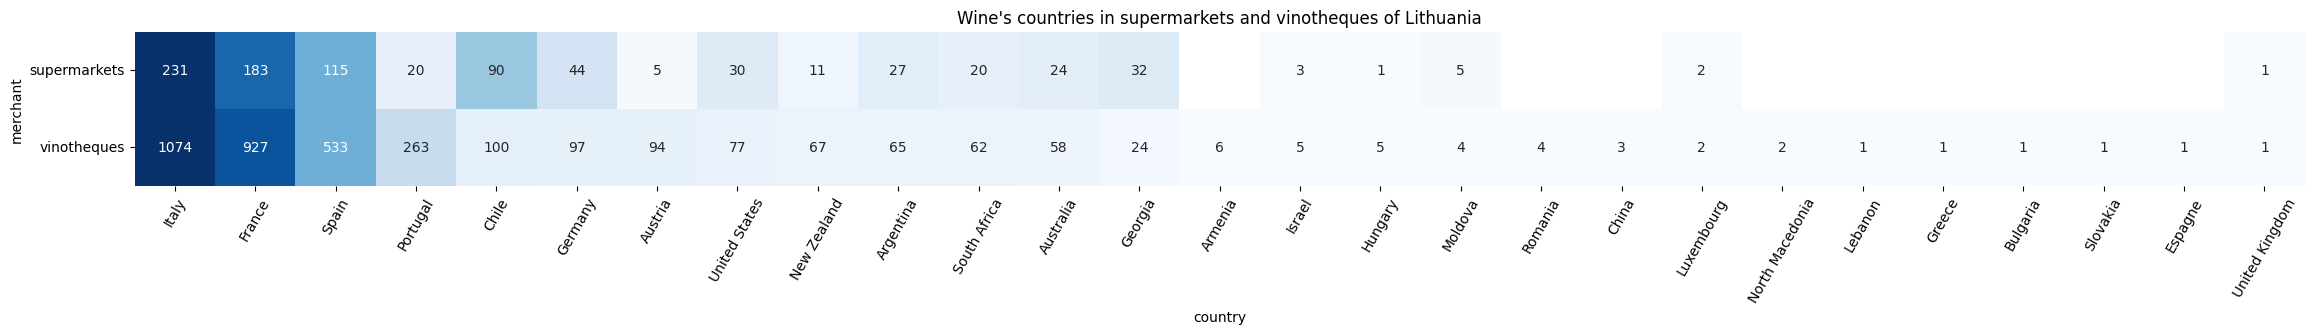

37

In [55]:
df_c = df[df['country'].isin(pop_country)].copy()
func_param_plot(crosstab=pd.crosstab(df_c['country'], df_c['merchant'], df_c['wine_id'],
                                     aggfunc='count').sort_values(by='vinotheques', ascending=False).T,
                workbook=workbook, sheet='Country', offset=offset,
                width=28, height=2, x_rotation=60, y_rotation=0,
                path_plot='plots', title_plot="Wine's countries in supermarkets and vinotheques of Lithuania",
                show=True, photo_num='2')

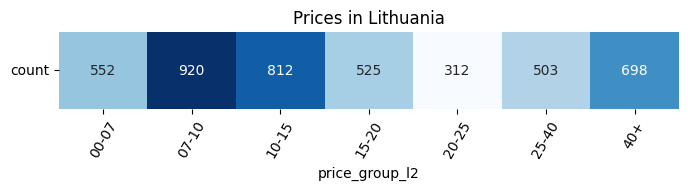

In [56]:
offset = func_param_plot(df=df, context='price_group_l2', research='wine_id', funcs=['count'],
                         workbook=workbook, sheet='Price', offset=0,
                         width=8, height=1, x_rotation=60, y_rotation=0,
                         path_plot='plots', title_plot='Prices in Lithuania',
                         title_sheet='Распределение вин по ценам',
                         show=True, photo_num='1')

In [26]:
func_param_examples(df, context='price_group_l2', research='score', funcs=['min','max'],
                             workbook=workbook, sheet='1', offset=offset,
                             top=5, show=False)

141

In [28]:
func_param_examples(df, context=['price_group_l2', 'region_big'], research='score', funcs=['min','max'],
                             workbook=workbook, sheet='2', offset=offset,
                             top=5, show=False)

6849

## Hypothesis checking

In [22]:
df.head(1)

,wine_id,merchant_name,price,price_avg,url,wine_name,wine_type_id,region,country,winery,style_name,style_body,acidity,grape_1,grape_2,grape_3,ratings_count_wine,ratings_average_wine,is_natural,critics_score_avg,style,score,region_big,price_group_l1,price_group_l2,score_group
0,4291453,Iki,27.9,22.5,https://iki.lt/alkoholiniai-gerimai/varvaglion...,Cosimo Varvaglione Collezione Privata Primitiv...,Red,Primitivo di Manduria,Italy,Varvaglione,Southern Italy Primitivo,4.0,3.0,Primitivo,NaN,NaN,4440,4.5,NaN,NaN,Smooth Red,9.1,Italy_other,17.34-24.05,25-40,9.0-9.5


In [23]:
file='.xlsx'; path='data'
xlfilepath = os.path.join(path, file)
workbook = xlsxwriter.Workbook(xlfilepath)

##

In [58]:
workbook.close()